In [1]:
import geopandas as gpd
import pandas as pd
import app_functions as f
from shapely.geometry import Point
from shapely.ops import unary_union
from datetime import datetime, timedelta, timezone
import os


root_dir=os.getcwd()

AOIs=gpd.read_file('./Areas_Of_Interest_For_ALERT/2024_Policies.geojson')
AOIs_buff=gpd.GeoDataFrame(data=AOIs,geometry=AOIs.buffer(0.7),crs=AOIs.crs)


C:\Users\alvaro.farias\AppData\Local\Temp\3\ipykernel_14784\3762280661.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  AOIs_buff=gpd.GeoDataFrame(data=AOIs,geometry=AOIs.buffer(0.7),crs=AOIs.crs)


In [11]:
def parse_datetime(value):
    """
    Attempt to parse a datetime value with multiple formats.
    """
    # Ensure value is a string; if it's NaN or float, return NaT
    if not isinstance(value, str):
        return pd.NaT
    
    datetime_formats = [
        "%Y-%m-%d %H:%M:%S",  # 2024-10-08 18:00:00
        "%d/%m/%Y %H:%M",      # 08/10/2024 18:00
        "%Y/%m/%d %H:%M:%S",   # 2024/10/08 18:00:00 (additional possible format)
    ]

    for fmt in datetime_formats:
        try:
            return datetime.strptime(value, fmt)
        except ValueError:
            continue
    
    # If none of the formats work, return None (or NaT)
    return pd.NaT

def get_recent_adeck_paths(file_path,timestamp_utc):
    """
    Get the adeck_path of storms whose end date is within the last 24 hours (UTC time).

    Parameters:
    - file_path: str, path to the storm_adeck_directory CSV file.
    - timestamp_utc: timestamp object, the time from which a storm is condered active (updated 24hrs prior to this time and date)

    Returns:
    - recent_adeck_paths: list of str, paths of adeck files updated in the last 24 hours.
    """
    try:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Parse 'Storm_End_Date' using the custom function
        df['Storm_End_Date'] = df['Storm_End_Date'].apply(parse_datetime)

        # Localize to UTC only if 'Storm_End_Date' is valid
        df['Storm_End_Date'] = df['Storm_End_Date'].apply(lambda x: x.tz_localize('UTC') if pd.notna(x) else x)

        # Time 24 hours ago in UTC
        time_threshold = timestamp_utc - timedelta(hours=24)

        # Filter rows whose 'Storm_End_Date' is within the last 24 hours
        recent_storms = df[df['Storm_End_Date'] > time_threshold]

        return recent_storms

    except Exception as e:
        print(f"Error occurred: {e}")
        return []
    
def clean_strings(gdf, column_name, new_column_name):
    """
    Removes any words containing numbers and all following words from the specified column 
    of the GeoDataFrame unless the word is the first word in the string.
    
    Parameters:
    gdf (GeoDataFrame): The input GeoDataFrame.
    column_name (str): The name of the column to be processed.
    new_column_name (str): The name of the new column where the cleaned strings will be stored.
    
    Returns:
    GeoDataFrame: The input GeoDataFrame with an additional column containing the cleaned strings.
    """
    
    def process_string(s):
        words = s.split()
        cleaned_words = []
        for i, word in enumerate(words):
            if i == 0:
                # Always keep the first word
                cleaned_words.append(word)
            else:
                if any(char.isdigit() for char in word):
                    # Remove this word and stop processing further words
                    break
                else:
                    cleaned_words.append(word)
        return ' '.join(cleaned_words).strip()
    
    # Apply the process_string function to the specified column
    gdf[new_column_name] = gdf[column_name].apply(process_string)
    
    return gdf

import plotly.graph_objects as go
import geopandas as gpd
import plotly.io as pio

def create_forecast_map_with_cone_for_AOIs(adeck_gdf, cone_polygon, aoi_gdf, selected_forecast_datetime=None, AOI_Name=None, logo_url=None,title=None):
    """
    Creates a Plotly map of the forecast tracks, including the uncertainty cone and areas of interest.

    Parameters:
    - adeck_gdf: GeoDataFrame with point geometries of the hurricane tracks.
    - cone_polygon: Polygon or MultiPolygon geometry representing the uncertainty cone.
    - aoi_gdf: GeoDataFrame with polygon geometries representing areas of interest.
    - selected_forecast_datetime: str, the forecast date and time in 'YYYYMMDDHH' format (optional).
    - AOI_Name: str, name of the column in aoi_gdf containing labels for AOIs, or a single label (str).

    Returns:
    - fig: Plotly figure object.
    """
    mapbox_access_token = 'pk.eyJ1IjoiYWx2YXJvZmFyaWFzIiwiYSI6ImNtMXptbm9iaDA4OHMybG9vc3VqdW1vZ3oifQ.ZJ8d6gNAiR1htIYxESOYuQ'
    pio.templates.default = 'plotly_dark'  # Optional to use dark theme

    # Filter by forecast datetime if provided
    if selected_forecast_datetime:
        adeck_gdf = adeck_gdf[adeck_gdf['DateTime'] == selected_forecast_datetime]

    # Determine AOI labels
    if AOI_Name and AOI_Name in aoi_gdf.columns:
        # Use the specified column for labels
        AOI_labels = aoi_gdf[AOI_Name].astype(str).tolist()
    else:
        # Use the provided AOI_Name as a single label, or default label
        AOI_label = AOI_Name if AOI_Name else 'Area(s) of Interest'
        AOI_labels = [AOI_label] * len(aoi_gdf)

    # Define category colors in the desired order
    category_colors = {
        'Tropical Depression': 'green',
        'Tropical Storm': 'blue',
        'Category 1': 'yellow',
        'Category 2': 'orange',
        'Category 3': 'red',
        'Category 4': 'purple',
        'Category 5': 'magenta',
        'Unknown': 'gray'
    }

    # Define the desired order for the legend
    category_order = [
        'Tropical Depression',
        'Tropical Storm',
        'Category 1',
        'Category 2',
        'Category 3',
        'Category 4',
        'Category 5',
        'Unknown'
    ]

    # Map category to colors
    adeck_gdf['Color'] = adeck_gdf['Category'].apply(lambda x: category_colors.get(x, 'gray'))

    # Sort the DataFrame by ModelName and ValidTime to ensure lines connect correctly per model
    adeck_gdf = adeck_gdf.sort_values(['ModelName', 'ValidTime'])

    # Initialize the Plotly figure
    fig = go.Figure()

    # Add a line trace for each model (white lines connecting points of the same model)
    models = adeck_gdf['ModelName'].unique()
    for model in models:
        model_gdf = adeck_gdf[adeck_gdf['ModelName'] == model].sort_values('ValidTime')
        if model_gdf.empty:
            continue
        fig.add_trace(go.Scattermapbox(
            lat=model_gdf.geometry.y,
            lon=model_gdf.geometry.x,
            mode='lines',
            line=dict(color='white', width=2),
            hoverinfo='none',  # No hover info for the lines
            showlegend=False    # Do not show lines in the legend
        ))

    # Group data by Category in the specified order and plot the markers
    for category in category_order:
        category_gdf = adeck_gdf[adeck_gdf['Category'] == category]
        if not category_gdf.empty:
            fig.add_trace(go.Scattermapbox(
                lat=category_gdf.geometry.y,
                lon=category_gdf.geometry.x,
                mode='markers',
                name=category,
                marker=dict(
                    size=8,
                    color=category_colors[category],  # Single color per category
                ),
                text=category_gdf.apply(
                    lambda row: (
                        f"Time: {row['ValidTime']:%Y-%m-%d %H:%M UTC}<br>"
                        f"Wind Speed (mph): {row['MaxWindSpeed_mph']:.1f}<br>"
                        f"Central Pressure (mb): {row['MinPressure']}<br>"
                        f"Category: {row['Category']}<br>"
                        f"Model: {row['ModelName']}"
                    ), axis=1),
                hoverinfo='text'
            ))

    # Add uncertainty cone polygon to the map
    if cone_polygon is not None and not cone_polygon.empty:
        # Ensure the cone_polygon is in WGS84 coordinate system
        if cone_polygon.crs != 'EPSG:4326':
            cone_polygon = cone_polygon.to_crs('EPSG:4326')
        
        for geom in cone_polygon.geometry:
            if geom.geom_type == 'Polygon':
                cone_coords = geom.exterior.coords.xy
                cone_lats, cone_lons = list(cone_coords[1]), list(cone_coords[0])  # Convert to lists
                fig.add_trace(go.Scattermapbox(
                    lat=cone_lats,
                    lon=cone_lons,
                    mode='lines',
                    fill='toself',
                    fillcolor='rgba(128, 128, 128, 0.5)',  # Grey with transparency
                    line=dict(color='lightgrey', width=2),  # Light grey outline
                    name='Uncertainty Cone',
                    hoverinfo='skip',  # No hover info for the cone
                    # Un-comment the next line if you want the cone to be off by default
                    # visible='legendonly'  
                ))
            elif geom.geom_type == 'MultiPolygon':
                for poly in geom.geoms:
                    cone_coords = poly.exterior.coords.xy
                    cone_lats, cone_lons = list(cone_coords[1]), list(cone_coords[0])  # Convert to lists
                    fig.add_trace(go.Scattermapbox(
                        lat=cone_lats,
                        lon=cone_lons,
                        mode='lines',
                        fill='toself',
                        fillcolor='rgba(128, 128, 128, 0.5)',  # Grey with transparency
                        line=dict(color='lightgrey', width=2),  # Light grey outline
                        name='Uncertainty Cone',
                        hoverinfo='skip',
                    ))

    # Add Areas of Interest polygons to the map
    if aoi_gdf is not None and not aoi_gdf.empty:
        # Ensure the aoi_gdf is in WGS84 coordinate system
        if aoi_gdf.crs != 'EPSG:4326':
            aoi_gdf = aoi_gdf.to_crs('EPSG:4326')

        # Iterate over each AOI polygon and their labels
        for idx, (aoi, label) in enumerate(zip(aoi_gdf.itertuples(), AOI_labels)):
            geometry = aoi.geometry
            if geometry.geom_type == 'Polygon':
                aoi_coords = geometry.exterior.coords.xy
                aoi_lats, aoi_lons = list(aoi_coords[1]), list(aoi_coords[0])  # Convert to lists
                fig.add_trace(go.Scattermapbox(
                    lat=aoi_lats,
                    lon=aoi_lons,
                    mode='lines',
                    fill='toself',
                    fillcolor='rgba(0, 255, 0, 0.2)',  # Green with transparency
                    line=dict(color='green', width=2),
                    name=label,
                    hoverinfo='skip'
                ))
            elif geometry.geom_type == 'MultiPolygon':
                for poly in geometry.geoms:
                    aoi_coords = poly.exterior.coords.xy
                    aoi_lats, aoi_lons = list(aoi_coords[1]), list(aoi_coords[0])  # Convert to lists
                    fig.add_trace(go.Scattermapbox(
                        lat=aoi_lats,
                        lon=aoi_lons,
                        mode='lines',
                        fill='toself',
                        fillcolor='rgba(0, 255, 0, 0.2)',  # Green with transparency
                        line=dict(color='green', width=2),
                        name=label,
                        hoverinfo='skip'
                    ))

    # Calculate the centroid of the AOIs and extract lat/lon for centering the map
    if not aoi_gdf.empty:
        aoi_centroid = aoi_gdf.centroid  # This gives a GeoSeries of centroids
        center_lat = aoi_centroid.y.mean()  # Calculate the mean latitude of the centroids
        center_lon = aoi_centroid.x.mean()  # Calculate the mean longitude of the centroids
    else:
        # If no AOIs, fallback to the adeck_gdf centroid
        center_lat = adeck_gdf.geometry.y.mean()
        center_lon = adeck_gdf.geometry.x.mean()

    # Set up the map layout with Mapbox token and style, centering on the AOI centroid
    fig.update_layout(
        mapbox_style='carto-darkmatter',
        mapbox_accesstoken=mapbox_access_token,  # Use Mapbox token
        mapbox_zoom=5,
        mapbox_center={"lat": center_lat, "lon": center_lon},  # Center the map on AOI centroid
        title=dict(text=title, font=dict(size=20, color='white'), x=0.5), 
        margin={"r": 0, "t": 50, "l": 0, "b": 0}
    )
    print(title)
    # Add a logo image if provided
    if logo_url:
        fig.add_layout_image(
            dict(
                source=logo_url,
                xref="paper", yref="paper",  # Position relative to the entire figure
                x=0.5, y=0.5,  # Position the logo at the top left corner
                sizex=5, sizey=10,  # Adjust size as necessary
                xanchor="left", yanchor="top",
                layer="above"
            )
        )

    return fig

import tempfile
import re
import win32com.client as win32
import plotly.graph_objects as go

def send_map_via_email(fig, recipients, subject, body, cc=None, bcc=None, sender=None, send_as=False):
    """
    Sends a Plotly map as an HTML attachment via Outlook email.

    Parameters:
    - fig (plotly.graph_objects.Figure): The Plotly figure to send.
    - recipients (list or str): List of recipient email addresses or a single email address.
    - subject (str): Subject of the email.
    - body (str): Body content of the email. Supports HTML.
    - cc (list or str, optional): List of CC email addresses or a single email address.
    - bcc (list or str, optional): List of BCC email addresses or a single email address.
    - sender (str, optional): Email address to send on behalf of. Must have permissions.
    - send_as (bool, optional): If True, attempts to set the 'From' property instead of 'SentOnBehalfOfName'.

    Returns:
    - None

    Raises:
    - ValueError: If no valid recipients are provided.
    - Exception: If Outlook is not installed or an error occurs during email sending.
    """
    try:
        # Function to validate email addresses using a simple regex
        def is_valid_email(email):
            regex = r'^[\w\.-]+@[\w\.-]+\.\w+$'
            return re.match(regex, email) is not None

        # Helper function to ensure input is a list
        def ensure_list(input_field):
            if input_field is None:
                return []
            if isinstance(input_field, str):
                input_field = input_field.strip()
                return [input_field] if input_field else []
            if isinstance(input_field, list):
                # Remove any empty strings and strip whitespace
                return [email.strip() for email in input_field if email.strip()]
            raise ValueError("Email fields must be either a string or a list of strings.")

        # Convert recipients, cc, bcc to lists
        recipients = ensure_list(recipients)
        cc = ensure_list(cc)
        bcc = ensure_list(bcc)

        # Combine all recipients to ensure at least one is present
        all_recipients = recipients + cc + bcc

        if not all_recipients:
            raise ValueError("At least one recipient must be provided in To, Cc, or Bcc.")

        # Validate all email addresses
        invalid_emails = [email for email in all_recipients if not is_valid_email(email)]
        if invalid_emails:
            raise ValueError(f"The following email addresses are invalid: {invalid_emails}")

        # Create a temporary directory to store the HTML file
        with tempfile.TemporaryDirectory() as tmpdirname:
            # Define the HTML file path
            html_file_path = os.path.join(tmpdirname, 'forecast_map.html')
            
            # Save the Plotly figure as an HTML file
            fig.write_html(html_file_path, full_html=True)
            
            # Initialize Outlook application
            outlook = win32.Dispatch('outlook.application')
            mail = outlook.CreateItem(0)  # 0: olMailItem
            
            # Set email parameters
            mail.Subject = subject
            mail.Body = body  # Plain text body
            mail.HTMLBody = body  # HTML body
            
            # Set sender if specified
            if sender:
                try:
                    if send_as:
                        mail.From = sender  # Requires 'Send As' permissions
                    else:
                        mail.SentOnBehalfOfName = sender  # Requires 'Send on Behalf Of' permissions
                except Exception as e:
                    print(f"Error setting sender to '{sender}': {e}")
                    raise

            # Add recipients to To
            for recipient in recipients:
                mail.Recipients.Add(recipient)
            
            # Add CC recipients
            for c in cc:
                mail.Recipients.Add(c)
            
            # Add BCC recipients
            for b in bcc:
                mail.Recipients.Add(b)
            
            # Resolve all recipients
            if not mail.Recipients.ResolveAll():
                unresolved = [rec.Name for rec in mail.Recipients if not rec.Resolved]
                raise ValueError(f"Some recipients could not be resolved: {unresolved}")
            
            # Attach the HTML file
            mail.Attachments.Add(Source=html_file_path)
            
            # Send the email
            mail.Send()
            
            print("Email sent successfully.")
    
    except ValueError as ve:
        print(f"ValueError: {ve}")
        raise
    except Exception as e:
        print(f"An error occurred while sending the email: {e}")
        raise

def read_adeck_dat_file_to_df_wo_cleaning(dat_file_path, model_name=None, forecast_datetime=None):

# Check if the file exists
    if not os.path.exists(dat_file_path):
        print(f"File not found: {dat_file_path}")
        return None

    # Define column names based on ATCF A-deck format
    columns = [
        'Basin', 'CycloneNumber', 'DateTime', 'ModelNumber', 'ModelName', 'ForecastHour',
        'Latitude', 'Longitude', 'MaxWindSpeed', 'MinPressure',
        'WindRad1', 'WindRad2', 'WindRad3', 'WindRad4', 'StormType',
        'Quadrant1', 'Quadrant2', 'Quadrant3', 'Quadrant4',
        'Radius1', 'Radius2', 'Radius3', 'Radius4',
        'StormName', 'Unused1', 'Unused2'
    ]
    data = []

    # Read the .dat file line by line
    try:
        with open(dat_file_path, 'r') as file:
            for line_number, line in enumerate(file, start=1):
                # Remove leading/trailing whitespace
                line = line.strip()
                # Skip empty lines
                if not line:
                    continue
                # Split the line into fields
                fields = line.split(',')
                # Strip whitespace from each field
                fields = [field.strip() for field in fields]
                # Handle variable number of fields
                # Create a dictionary for this line
                record = {}
                num_fields = len(fields)
                for i in range(min(num_fields, len(columns))):
                    record[columns[i]] = fields[i]
                # If there are extra fields, add them as 'ExtraField1', 'ExtraField2', etc.
                if num_fields > len(columns):
                    for j in range(len(columns), num_fields):
                        record[f'ExtraField{j - len(columns) + 1}'] = fields[j]
                data.append(record)
    except Exception as e:
        print(f"Error reading .dat file at line {line_number}: {e}")
        return None

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)

    if df.empty:
        print("No data found for the selected forecast date and time.")
        return None

    # Convert columns to appropriate data types
    df['ForecastHour'] = pd.to_numeric(df['ForecastHour'], errors='coerce')
    df['MaxWindSpeed'] = pd.to_numeric(df['MaxWindSpeed'], errors='coerce')
    df['MaxWindSpeed_mph'] = df['MaxWindSpeed'] * 1.15078  # Knots to miles per hour
    df['Latitude'] = df['Latitude'].apply(f.parse_lat_lon)
    df['Longitude'] = df['Longitude'].apply(f.parse_lat_lon)
    df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y%m%d%H', errors='coerce')
    df['DateTime'] =  df['DateTime'].dt.tz_localize('UTC')

    return(df)

In [3]:
        # Set the current timestamp in UTC
        timestamp_utc = datetime.now(timezone.utc)

        # Get the current UTC time
        now_utc = datetime.now(timezone.utc)

        # Define the forecast issuance hours
        forecast_hours = [0, 6, 12, 18]

        # Get the current hour
        current_hour = now_utc.hour

        # Find the latest forecast hour less than or equal to the current hour
        valid_hours = [hour for hour in forecast_hours if hour <= current_hour]

        if valid_hours:
            # If there is a valid forecast hour, use the latest one
            latest_forecast_hour = max(valid_hours)
            # Set timestamp_utc to today at the latest forecast hour
            timestamp_utc = now_utc.replace(hour=latest_forecast_hour, minute=0, second=0, microsecond=0)
        else:
            # If current hour is before the first forecast hour (shouldn't happen but included for completeness)
            # Go back to the previous day's last forecast hour
            latest_forecast_hour = 18
            timestamp_utc = (now_utc - timedelta(days=1)).replace(hour=latest_forecast_hour, minute=0, second=0, microsecond=0)

        print(f"Current UTC time: {now_utc}")
        print(f"Adjusted timestamp_utc: {timestamp_utc}")

Current UTC time: 2024-10-11 18:52:18.851035+00:00
Adjusted timestamp_utc: 2024-10-11 18:00:00+00:00


In [4]:

# Get the current time in UTC
timestamp_utc = timestamp_utc
#timestamp_utc = pd.to_datetime("2024-10-07 12:00").tz_localize('UTC')

recent_adeck_paths = get_recent_adeck_paths(root_dir+'./storm_adeck_directory.csv',timestamp_utc)
recent_adeck_paths=recent_adeck_paths[recent_adeck_paths['Storm_Name']!='Invest'] #Remove Invests from list
recent_adeck_paths 

,Basin,Storm_Number,Storm_Name,Storm_Start_Date,Storm_End_Date,Storm_Year,adeck_path
247,al,13,Leslie,2024-09-30 18:00:00,2024-10-11 12:00:00+00:00,2024.0,./forecast_data/aal132024.dat
3070,al,14,Milton,2024-10-05 00:00:00,2024-10-11 00:00:00+00:00,2024.0,./forecast_data/aal142024.dat


In [13]:
storm_dat=read_adeck_dat_file_to_df_wo_cleaning(row['adeck_path'],forecast_datetime=timestamp_utc)
storm_dat

# Filter by forecast datetime if provided
if timestamp_utc:
    storm_dat = storm_dat[storm_dat['DateTime'] == timestamp_utc]
storm_dat

NameError: name 'df' is not defined

In [5]:
cones=gpd.GeoDataFrame()
for index, row in recent_adeck_paths.iterrows():
    storm_dat=f.read_adeck_dat_file_to_gdf(row['adeck_path'],forecast_datetime=timestamp_utc)
    try:
        if len(storm_dat[storm_dat['ForecastHour']>0])>0:
            cone=f.create_uncertainty_cone(storm_dat)
            cone['Basin']=row['Basin']
            cone['Storm_Number']=row['Storm_Number']
            cone['Storm_Name']=row['Storm_Name']
            cone['last_update']=row['Storm_End_Date']
            cone['adeck_path']=row['adeck_path']
            cones=pd.concat([cone,cones])
        else: #There are no forecasts for this storm
            print('There are no forecasts for storm ' + row['Storm_Name'])
    except Exception as e:
        print(f"Appears we have no data for storm {row['Storm_Name']}")

All data has been dropped after removing rows with missing values.
Appears we have no data for storm Leslie
All data has been dropped after removing rows with missing values.
Appears we have no data for storm Milton


In [61]:
d=f.read_adeck_dat_file_to_gdf('./forecast_data/aal142024.dat',forecast_datetime=timestamp_utc)
ofcl_gdf=f.filter_adeck_gdf_for_official_model(d)
ofcl_gdf

Removed 37 rows with Latitude or Longitude equal to 0.


c:\ProgramData\anaconda3\envs\EventMonitor\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Basin,CycloneNumber,DateTime,ModelNumber,ModelName,ForecastHour,Latitude,Longitude,MaxWindSpeed,MinPressure,...,ExtraField15,ExtraField16,ExtraField17,ExtraField18,ExtraField19,ExtraField20,MaxWindSpeed_mph,ValidTime,Category,geometry
48328,AL,14,2024-10-07 12:00:00+00:00,03,OFCL,0,21.8,-92.2,120,0,...,NaN,NaN,NaN,NaN,NaN,NaN,138.0936,2024-10-07 12:00:00+00:00,Category 4,POINT (-92.20000 21.80000)
48329,AL,14,2024-10-07 12:00:00+00:00,03,OFCL,0,21.8,-92.2,120,0,...,NaN,NaN,NaN,NaN,NaN,NaN,138.0936,2024-10-07 12:00:00+00:00,Category 4,POINT (-92.20000 21.80000)
48330,AL,14,2024-10-07 12:00:00+00:00,03,OFCL,0,21.8,-92.2,120,0,...,NaN,NaN,NaN,NaN,NaN,NaN,138.0936,2024-10-07 12:00:00+00:00,Category 4,POINT (-92.20000 21.80000)
48331,AL,14,2024-10-07 12:00:00+00:00,03,OFCL,3,21.7,-91.7,135,933,...,NaN,NaN,NaN,NaN,NaN,NaN,155.3553,2024-10-07 15:00:00+00:00,Category 4,POINT (-91.70000 21.70000)
48332,AL,14,2024-10-07 12:00:00+00:00,03,OFCL,3,21.7,-91.7,135,933,...,NaN,NaN,NaN,NaN,NaN,NaN,155.3553,2024-10-07 15:00:00+00:00,Category 4,POINT (-91.70000 21.70000)
48333,AL,14,2024-10-07 12:00:00+00:00,03,OFCL,3,21.7,-91.7,135,933,...,NaN,NaN,NaN,NaN,NaN,NaN,155.3553,2024-10-07 15:00:00+00:00,Category 4,POINT (-91.70000 21.70000)
48334,AL,14,2024-10-07 12:00:00+00:00,03,OFCL,12,21.5,-90.4,145,0,...,NaN,NaN,NaN,NaN,NaN,NaN,166.8631,2024-10-08 00:00:00+00:00,Category 5,POINT (-90.40000 21.50000)
48335,AL,14,2024-10-07 12:00:00+00:00,03,OFCL,12,21.5,-90.4,145,0,...,NaN,NaN,NaN,NaN,NaN,NaN,166.8631,2024-10-08 00:00:00+00:00,Category 5,POINT (-90.40000 21.50000)
48336,AL,14,2024-10-07 12:00:00+00:00,03,OFCL,12,21.5,-90.4,145,0,...,NaN,NaN,NaN,NaN,NaN,NaN,166.8631,2024-10-08 00:00:00+00:00,Category 5,POINT (-90.40000 21.50000)
48337,AL,14,2024-10-07 12:00:00+00:00,03,OFCL,24,22.2,-88.3,140,0,...,NaN,NaN,NaN,NaN,NaN,NaN,161.1092,2024-10-08 12:00:00+00:00,Category 5,POINT (-88.30000 22.20000)


<Axes: >

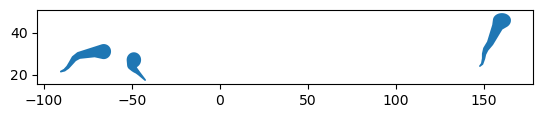

In [62]:
cones.plot()

In [63]:
intercepts=gpd.GeoDataFrame()
for index, row in cones.iterrows():
    row_gdf = gpd.GeoDataFrame([row], geometry='geometry', crs=cones.crs)
    intercept=gpd.overlay(AOIs_buff,row_gdf)
    intercepts=pd.concat([intercept,intercepts])

intercepts=clean_strings(intercepts,'Name','ClientName')
AOIs=clean_strings(AOIs,'Name','ClientName')

In [153]:
affected_clients=intercepts['ClientName'].unique()
if len(affected_clients)==0:
    print("No clients affected by currently active storms")
else:
    for affc in affected_clients:
        rel_intercept=intercepts[intercepts['ClientName']==affc]
        
        for storm in rel_intercept["Storm_Name"].unique():
            rel_intercept=rel_intercept[rel_intercept['Storm_Name']==storm]
            adeck_gdf=f.read_adeck_dat_file_to_gdf(rel_intercept['adeck_path'].unique()[0],forecast_datetime=timestamp_utc)#)
            adeck_gdf=f.filter_adeck_gdf_for_official_model(adeck_gdf)
            cone=cones[cones['Storm_Name']==storm]

            logo_path='Z:\\Event_Monitor\\logos\\LOCKTON_logo-white-footer.svg'
            Title=f"Lockton Alert for {storm}"

            fig=create_forecast_map_with_cone_for_AOIs(adeck_gdf,cone,AOIs[AOIs['ClientName']==affc],AOI_Name='Name',title=Title,logo_url=logo_path)

            filename=f"client_storm_alerts/{affc}-{storm}-forecast-{timestamp_utc.strftime('%Y-%m-%d %H:%M')}.html"
            filename= filename.replace(':', '-')

            fig.write_html(f'./{filename}')

            #Send the email

            # Define email parameters
            recipients = ['alvaro.farias@lockton.com','DMonsalve@lockton.com']

            subject = f'Forecast Map - {storm}'
            body = f"""
            <html>
            <head></head>
            <body>
                <p>Dear Team,</p>
                <p>Please find the attached forecast map for <b>{storm}</b> based on the Official Forecast made on <b>{timestamp_utc} UTC</b> </p>
                <p>Best regards,<br>Lockton Storm Monitor</p>
            </body>
            </html>
            """

            # Optional parameters
            cc = ['']
            bcc = ['']
            sender = 'alvaro.farias@lockton.com'  # Optional: specify if needed

            # Send the email
            send_map_via_email(fig, recipients, subject, body, cc=cc, bcc=bcc, sender=sender)


Removed 37 rows with Latitude or Longitude equal to 0.


c:\ProgramData\anaconda3\envs\EventMonitor\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alvaro.farias\AppData\Local\Temp\3\ipykernel_11968\1859477117.py:275: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Lockton Alert for Milton
Email sent successfully.
Removed 37 rows with Latitude or Longitude equal to 0.


c:\ProgramData\anaconda3\envs\EventMonitor\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alvaro.farias\AppData\Local\Temp\3\ipykernel_11968\1859477117.py:275: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Lockton Alert for Milton
Email sent successfully.
Removed 37 rows with Latitude or Longitude equal to 0.


c:\ProgramData\anaconda3\envs\EventMonitor\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alvaro.farias\AppData\Local\Temp\3\ipykernel_11968\1859477117.py:275: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Lockton Alert for Milton
Email sent successfully.
Removed 37 rows with Latitude or Longitude equal to 0.


c:\ProgramData\anaconda3\envs\EventMonitor\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alvaro.farias\AppData\Local\Temp\3\ipykernel_11968\1859477117.py:275: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Lockton Alert for Milton
Email sent successfully.


In [143]:
fig.show()